<a href="https://colab.research.google.com/github/abubakerKhaled/Cars-Classification/blob/main/02_ResNet_Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import random
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import StratifiedShuffleSplit
from google.colab import drive


drive.mount('/content/drive')


PROJECT_PATH = '/content/drive/MyDrive/StanfordCars_Project'
MODELS_PATH = os.path.join(PROJECT_PATH, 'models')
RESULTS_PATH = os.path.join(PROJECT_PATH, 'results')
DATA_PATH = os.path.join(PROJECT_PATH, 'stanford_cars_top20')

os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True);

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print(f"Connected to Project. Models will be saved to: {MODELS_PATH}")


train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

if not os.path.exists(DATA_PATH):
    print(f"ERROR: Data not found at {DATA_PATH}")
else:
    print(f"Found data at: {DATA_PATH}")
    full_dataset = datasets.ImageFolder(root=DATA_PATH)
    targets = full_dataset.targets
    class_names = full_dataset.classes

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(splitter.split(np.zeros(len(targets)), targets))

    class CustomDataset(Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform

        def __getitem__(self, index):
            x, y = self.subset[index]
            if self.transform:
                x = self.transform(x)
            return x, y

        def __len__(self):
            return len(self.subset)

    train_dataset = CustomDataset(Subset(full_dataset, train_idx), transform=train_transform)
    val_dataset = CustomDataset(Subset(full_dataset, val_idx), transform=val_transform)

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f"Data Loaded! Training on {len(train_dataset)} images, Validating on {len(val_dataset)} images.")
    print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Mounted at /content/drive
Connected to Project. Models will be saved to: /content/drive/MyDrive/StanfordCars_Project/models
Found data at: /content/drive/MyDrive/StanfordCars_Project/stanford_cars_top20
Data Loaded! Training on 757 images, Validating on 190 images.
Device: cuda


In [ ]:

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    since = time.time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print(f"Engine Start. Device: {device}")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device);

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history


print("Downloading ResNet-50...")
model_resnet = models.resnet50(weights='IMAGENET1K_V1')

for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
print(f"Original Input Features to Classifier: {num_ftrs}")

num_classes = len(full_dataset.classes)
model_resnet.fc = nn.Linear(num_ftrs, num_classes);

print(f"Surgery Complete. New Head Output: {num_classes} classes.")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


Original Input Features to Classifier: 2048
Surgery Complete. New Head Output: 20 classes.


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_resnet.fc.parameters(), lr=0.001, momentum=0.9);

trained_resnet, resnet_history = train_model(
    model_resnet,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=10
)

Engine Start. Device: cuda
Epoch 1/10
----------
train Loss: 3.0185 Acc: 0.0489
val Loss: 2.9295 Acc: 0.0842
Epoch 2/10
----------
train Loss: 2.8637 Acc: 0.1691
val Loss: 2.7616 Acc: 0.2211
Epoch 3/10
----------
train Loss: 2.7318 Acc: 0.2219
val Loss: 2.6246 Acc: 0.3316
Epoch 4/10
----------
train Loss: 2.5520 Acc: 0.3606
val Loss: 2.5051 Acc: 0.3421
Epoch 5/10
----------
train Loss: 2.4521 Acc: 0.3791
val Loss: 2.3932 Acc: 0.4105
Epoch 6/10
----------
train Loss: 2.3313 Acc: 0.4597
val Loss: 2.3138 Acc: 0.4053
Epoch 7/10
----------
train Loss: 2.2320 Acc: 0.4927
val Loss: 2.2333 Acc: 0.4316
Epoch 8/10
----------
train Loss: 2.1402 Acc: 0.5231
val Loss: 2.1645 Acc: 0.4526
Epoch 9/10
----------
train Loss: 2.0339 Acc: 0.5865
val Loss: 2.1018 Acc: 0.4895
Epoch 10/10
----------
train Loss: 1.9827 Acc: 0.5786
val Loss: 2.0467 Acc: 0.4737
Training complete in 3m 44s
Best val Acc: 0.489474


In [ ]:
print("Unfreezing ResNet Layer 4 for Fine-Tuning...")

for param in model_resnet.layer4.parameters():
    param.requires_grad = True


optimizer_ft = optim.SGD([
    {'params': model_resnet.layer4.parameters(), 'lr': 0.0001},
    {'params': model_resnet.fc.parameters(), 'lr': 0.001}
], momentum=0.9)

print("Starting Fine-Tuning Phase...")
trained_resnet, resnet_history_ft = train_model(
    model_resnet,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    num_epochs=15
)

Unfreezing ResNet Layer 4 for Fine-Tuning...
Starting Fine-Tuning Phase...
Engine Start. Device: cuda
Epoch 1/15
----------
train Loss: 1.9580 Acc: 0.6116
val Loss: 2.0433 Acc: 0.4947
Epoch 2/15
----------
train Loss: 1.9252 Acc: 0.6037
val Loss: 1.9689 Acc: 0.5211
Epoch 3/15
----------
train Loss: 1.8248 Acc: 0.6103
val Loss: 1.9041 Acc: 0.5158
Epoch 4/15
----------
train Loss: 1.7383 Acc: 0.6380
val Loss: 1.8311 Acc: 0.5368
Epoch 5/15
----------
train Loss: 1.6578 Acc: 0.6803
val Loss: 1.7672 Acc: 0.5421
Epoch 6/15
----------
train Loss: 1.5739 Acc: 0.6671
val Loss: 1.7204 Acc: 0.5316
Epoch 7/15
----------
train Loss: 1.5142 Acc: 0.6988
val Loss: 1.6544 Acc: 0.5632
Epoch 8/15
----------
train Loss: 1.4261 Acc: 0.7213
val Loss: 1.6032 Acc: 0.5737
Epoch 9/15
----------
train Loss: 1.3581 Acc: 0.7279
val Loss: 1.5570 Acc: 0.5789
Epoch 10/15
----------
train Loss: 1.3135 Acc: 0.7358
val Loss: 1.5129 Acc: 0.6000
Epoch 11/15
----------
train Loss: 1.2327 Acc: 0.7649
val Loss: 1.4668 Acc: 0

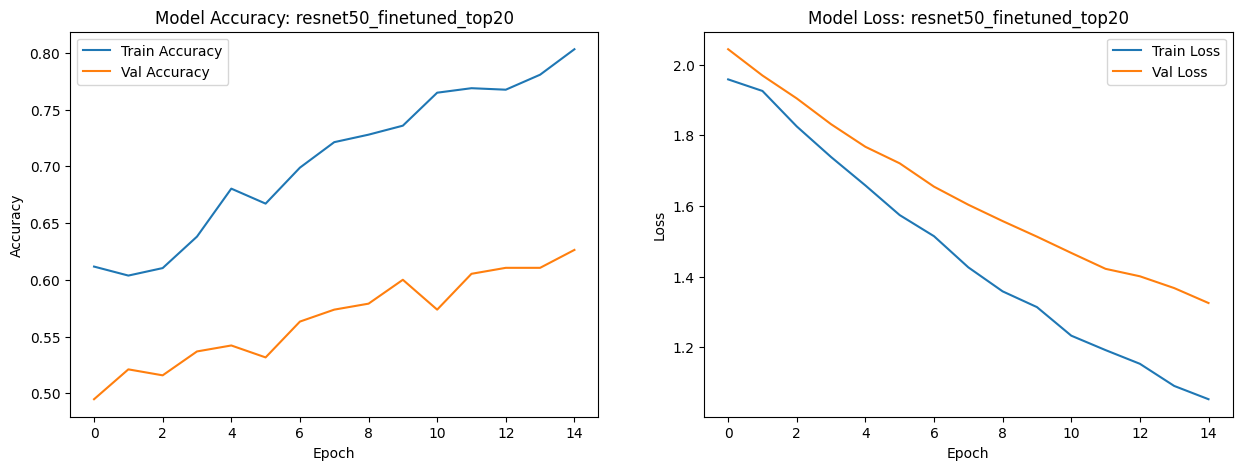

Generating Detailed Report...
                                          precision    recall  f1-score   support

                      Audi S6 Sedan 2011       0.58      0.78      0.67         9
       Bentley Continental GT Coupe 2007       0.57      0.44      0.50         9
     Cadillac Escalade EXT Crew Cab 2007       0.58      0.78      0.67         9
             Chevrolet Corvette ZR1 2012       0.47      0.70      0.56        10
             Chevrolet Malibu Sedan 2007       0.64      0.78      0.70         9
                 Chrysler 300 SRT-8 2010       0.50      0.60      0.55        10
                  Dodge Durango SUV 2007       1.00      0.33      0.50         9
              Eagle Talon Hatchback 1998       0.67      0.67      0.67         9
                      Ford GT Coupe 2006       0.78      0.78      0.78         9
                     GMC Savana Van 2012       0.87      0.93      0.90        14
              Geo Metro Convertible 1993       0.78      0.78      

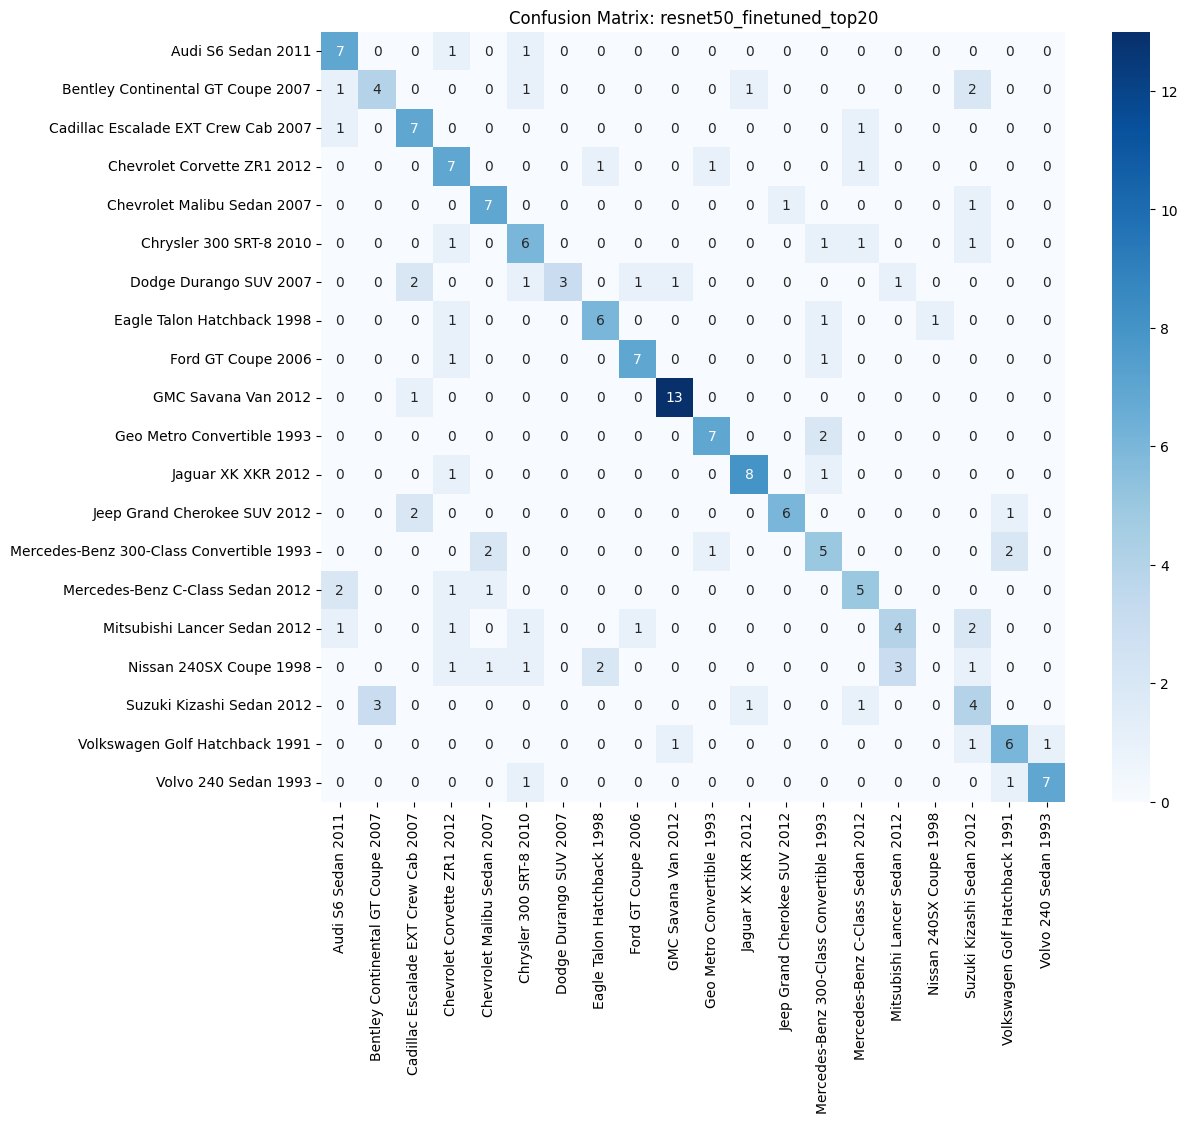

✅ Success! Saved resnet50_finetuned_top20 to Drive.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
import os

def evaluate_and_save(model, history, val_loader, class_names, save_name):
    MODELS_PATH = os.path.join(PROJECT_PATH, 'models')
    RESULTS_PATH = os.path.join(PROJECT_PATH, 'results')
    os.makedirs(MODELS_PATH, exist_ok=True)
    os.makedirs(RESULTS_PATH, exist_ok=True);

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(history['train_acc'], label='Train Accuracy')
    ax[0].plot(history['val_acc'], label='Val Accuracy')
    ax[0].set_title(f'Model Accuracy: {save_name}')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history['train_loss'], label='Train Loss')
    ax[1].plot(history['val_loss'], label='Val Loss')
    ax[1].set_title(f'Model Loss: {save_name}')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig(f"{RESULTS_PATH}/{save_name}_curves.png")
    plt.show()

    print("Generating Detailed Report...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=0)
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {save_name}')
    plt.savefig(f"{RESULTS_PATH}/{save_name}_cm.png")
    plt.show()

    torch.save(model.state_dict(), f"{MODELS_PATH}/{save_name}.pth")

    final_data = {
        "history": history,
        "report": report_dict
    }

    with open(f"{RESULTS_PATH}/{save_name}_metrics.json", 'w') as f:
        json.dump(final_data, f)

    print(f"✅ Success! Saved {save_name} to Drive.")

evaluate_and_save(
    trained_resnet,
    resnet_history_ft,
    val_loader,
    class_names,
    "resnet50_finetuned_top20"
)